In [3]:
# %load gen_data.py
import math
import numpy as np
import matplotlib.pyplot as plt

n_range = 40
n_times = 1000
n_dims = 3
np.random.seed(2)
x = np.empty((n_dims, n_times), 'int64')
start = np.random.randint(-4*n_range, 4*n_range, n_dims).reshape(n_dims, 1)

x[:] = start + np.array(range(n_times)) 
data = np.sin(x / 1.0 / n_range).astype('float64').T
np.save('./data.npy', data)

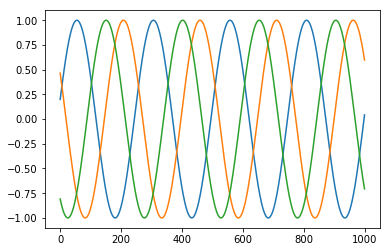

In [4]:
%matplotlib inline
plt.plot(data)

In [1]:
# %load train.py
""" Recurrent Neural Network Time Series.

A Recurrent Neural Network (LSTM) multivariate time series forecasting implementation 
Minimalist example using TensorFlow library.

Links:
    [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
    [dataset Dataset](http://yann.lecun.com/exdb/dataset/).
"""

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

# Import dataset data
from reader import read_data_sets
dataset = read_data_sets("./data.npy")


'''
To forecast time series using a recurrent neural network, we consider every 
row as a sequence of short time series. Because dataset times series has 9 dim, we will then
handle 9 sequences for every sample.
'''

# Training Parameters
learning_rate = 0.01
training_steps = 1000
batch_size = 128
display_step = 200

# Network Parameters
num_input = 3 # dataset data input (time series dimension: 9)
timesteps = 10 # timesteps
num_hidden = 128 # hidden layer num of features
num_layers = 2 # number of layers

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, timesteps, num_input])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_input]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_input]))
}


def RNN(x,  weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    def lstm_cell():
        return tf.contrib.rnn.BasicLSTMCell(num_hidden,forget_bias=1.0)


#     lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    stacked_lstm = tf.contrib.rnn.MultiRNNCell(
        [lstm_cell() for _ in range(num_layers)])

    # Get lstm cell output
    outputs, states = rnn.static_rnn(stacked_lstm, x, dtype=tf.float32)
 
    # Linear activation, using rnn inner loop last output
    logits = []
    for output in outputs:
        logit = tf.matmul(output, weights['out']) + biases['out']
        logits.append(logit) 
    logits= tf.stack(logits, 1)
    return logits

logits = RNN(X,  weights, biases)
prediction = tf.nn.tanh(logits)

# Define loss and optimizer

loss_op = tf.reduce_mean(tf.squared_difference(prediction, Y))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 dataset test inps
    test_len = 128
    test_data = dataset.test.inps[:test_len].reshape((-1, timesteps, num_input))
    test_label = dataset.test.outs[:test_len]
    
    # Fetch the predictions 
    fetches = {
        "true":Y,
        "pred":prediction,
        "accuracy":accuracy
    }
    vals = sess.run(fetches, feed_dict={X: test_data, Y: test_label})
    print("Testing Accuracy:", vals["accuracy"])


loading time series ...
input type  <class 'numpy.ndarray'> (1000, 3)
Step 1, Minibatch Loss= 0.2901, Training Accuracy= 0.581
Step 200, Minibatch Loss= 0.0311, Training Accuracy= 0.469
Step 400, Minibatch Loss= 0.0077, Training Accuracy= 0.625
Step 600, Minibatch Loss= 0.0045, Training Accuracy= 0.661
Step 800, Minibatch Loss= 0.0039, Training Accuracy= 0.849
Step 1000, Minibatch Loss= 0.0010, Training Accuracy= 0.784
Optimization Finished!
Testing Accuracy: 0.748148


(90, 10, 3)


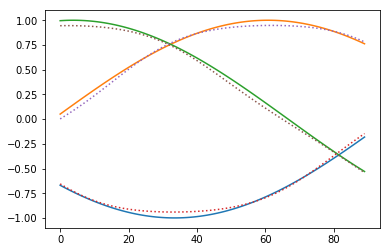

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

y_pred = vals["pred"]
y_true = vals["true"]
print((y_pred.shape))
plt.plot(y_true[:,0,:],'-')
plt.plot(y_pred[:,0,:],':')
